# Preface

This notebook was downloaded from [an excellent tutorial](http://online.cambridgecoding.com/notebooks/mhaller/predicting-user-preferences-in-python-using-alternating-least-squares). Most of it is unchanged, but I made a couple modifications to demonstrate the speedup that can be achieved by taking advantage of the inherent sparseness of the data used in these recommender systems. I discuss what I've done here in more detail in [a blog post on my website](http://www.benjlindsay.com/blog/taking-advantage-of-sparsity-in-als-wr-algorithm/). Many thanks to Moritz Haller and Agnes for making this tutorial and associated code publicly available!

# Predicting User Preferences in Python using Alternating Least Squares

In a previous [tutorial](http://online.cambridgecoding.com/notebooks/eWReNYcAfB/implementing-your-own-recommender-systems-in-python-2) you've learned about a powerful technique for automating item recommendations based on user's previous behaviour called **Collaborative Filtering** (CF). You implemented both the memory-based and the model-based method. For the memory-based method you used cosine similarity to calculate how similar users and/or items are. For the model-based method you utilised the fact that a matrix can be decomposed into a product of matrices, much like an integer can be factorised as a product of two integers (e.g., $10 = 2 \times 5$):

<img class="aligncenter size-thumbnail img-responsive" src="https://s32.postimg.org/721lra91h/matrix.png" style="max-width:100%; width: 50%" alt="UV Decomposition"/>

In this tutorial you will learn in more detail how to solve the matrix factorisation problem shown in the figure above. The so-called $UV$-decomposition aims to approximately represent the rating matrix as a product of two matrices (usually called $U$ and $V$, hence the name). The challenge is to find the two underlying matrices, based on the few ratings you observed in the rating matrix. In the last [tutorial](http://online.cambridgecoding.com/notebooks/mhaller/implementing-your-own-recommender-systems-in-python-using-stochastic-gradient-descent-4#implementing-your-own-recommender-systems-in-python-using-stochastic-gradient-descent) you learned how to solve this problem using Stochastic Gradient Descent (SGD). Today you'll learn about another approach to finding the two matrices, called **Alternating Least Squares** (**ALS**). In this tutorial you will 

- gain some intuition about what ALS is,
- derive the ALS algorithm,
- train the model, and
- make actual recommendations to users.

## What is Alternating Least Squares (ALS)?
Before strictly defining ALS, let's first think about the overall goal. The goal is to complete the rating matrix, i.e to accurately predict every user's rating for the movies they haven't watched yet. By predicting ratings accurately, you can suggest the most suitable movies to watch next to each user individually. Doing so will [keep the customers satisfied](https://www.youtube.com/watch?v=3YNsZLtzF18)!

The rating matrix is your central data structure. When following the $UV$-decomposition approach, every rating can be considered a weighted linear combination of latent user and movie factors as shown in the figure below.

<img class="aligncenter size-thumbnail img-responsive" src="https://s32.postimg.org/4q9bmkfpx/matrix_mult.png" style="max-width:100%; width: 50%" alt="Matrix Multiplication"/>

Now recall how matrix multiplication works: To yield rating $r_{11}$ in the figure above, you have to take the dot product of the first row vector of $P^T$ and the first column vector of $Q$. You can interpret this operation as the sum of latent user features, weighted by the respective latent movie features. If you knew the latent movie features this would be a [simple linear regression](https://en.wikipedia.org/wiki/Simple_linear_regression) problem. Since you don't know any of the latent features you'll use the trick of alternating least squares. **You assume to know the unknown movie features by randomly initialising the movie feature matrix $Q$**. You then estimate the user feature matrix for every user (row by row). After that you use this estimate of the user feature matrix to estiamte the movie feature matrix for every movie (column by column). If you repeat this procedure for every non-empty cell in the rating matrix a few times, you should get a pretty good approximation of the whole rating matrix.

## Getting Ready
Before deriving the algorithm let's prepare the development environment. Like the last time, let's import the [Movielens](http://files.grouplens.org/datasets/movielens/ml-100k.zip) data set and pre-process it by splitting the data into a training and test data set.

In [1]:
import numpy as np
import pandas as pd
header = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('./ml-100k/u.data', sep='\t', names=header)
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items))

Number of users = 943 | Number of movies = 1682


In [2]:
from sklearn import cross_validation as cv
train_data, test_data = cv.train_test_split(df,test_size=0.25)

train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

# Create training and test matrix
R = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    R[line[1]-1, line[2]-1] = line[3]  

T = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    T[line[1]-1, line[2]-1] = line[3]

/Users/benlindsay/miniconda/envs/yelp/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Next, let's define a "selector" matrix $I$ for your training data matrix $R$, which will contain $0$ if the rating matrix has no rating entry, and $1$ if the rating matrix contains an entry. This will come in handy later, when you want to select the appropriate rows and columns for estimating the parameters. Let's do the same for the test data matrix $T$ and call the selector matrix $I_2$.

In [3]:
# Index matrix for training data
I = R.copy()
I[I > 0] = 1
I[I == 0] = 0

# Index matrix for test data
I2 = T.copy()
I2[I2 > 0] = 1
I2[I2 == 0] = 0

To evaluate the performance of the model, you'll again use the root mean squared error (RMSE). Using the mean error rather than the sum of squared errors (SSD) has the benefit of making training and test error comparable due to normalisation. Since you only want to evaluate the performance based on observed ratings, select the appropriate rows and columns with the previously defined "selector" matrix $I$ and normalise the error by the number of ratings $R[R > 0]$.

In [4]:
# Calculate the RMSE
def rmse(I,R,Q,P):
    return np.sqrt(np.sum((I * (R - np.dot(P.T,Q)))**2)/len(R[R > 0]))

## Deriving the ALS Algorithm
Building upon the intuition from the beginning of the tutorial, let's define the model more thoroughly. Remember that you are trying to estimate two unknown matrices which, when multiplied together, yield the rating matrix. The loss function you will use is the well-known sum of squared errors. The second term is for regularisation to prevent overfitting (don't worry about it too much):

<img src="https://latex.codecogs.com/gif.latex?\underset{Q*&space;,&space;P*}{min}\sum_{(u,i)\epsilon&space;K&space;}(r_{ui}-P_u^TQ_i)^2&plus;\lambda(\left&space;\|&space;Q_i&space;\right&space;\|^2&space;&plus;&space;\left&space;\|&space;P_u&space;\right&space;\|^2)$&space;&space;$(1)" title="\underset{q* , p*}{min}\sum_{(u,i)\epsilon K }(r_{ui}-q_i^Tp_u)^2+\lambda(\left \| q_i \right \|^2 + \left \| p_u \right \|^2)" />


Without the assumption of knowning one of the matrices $P$ or $Q$ up front, the problem is non-convex, i.e. it is not so easy to find a global optimum for your loss function. However, if you use the ALS trick to fix one of the matrices at each step, you can turn the non-convex optimisation problem into a quadratic (least squares) problem. Each step then boils down to solving an (overdetermined) system of linear equations. To find the actual update rules on how to calculate the rows of the matrices $P$ and $Q$ in each step, you have to find the global minimum of the loss function twice: once while considering $P$ to be a parameter and once while considering $Q$ to be a parameter. Luckliy you don't need to do the math, since [Zhou et al. (2008)](http://www.grappa.univ-lille3.fr/~mary/cours/stats/centrale/reco/paper/MatrixFactorizationALS.pdf) already did it in their paper "*Large-scale Parallel Collaborative Filtering for the Netflix Prize*" (with a slightly different regularization term). Differentiating the loss function w.r.t each parameter, equating to zero and solving for the respective paramter yields the following update equations:

<img src="https://latex.codecogs.com/gif.latex?\mathbf{p}_{i}&space;=&space;A^{-1}_{i}&space;V_{i}&space;\&space;with\&space;A_{i}&space;=&space;Q_{I_i}&space;Q_{I_i}^{T}&space;&plus;&space;\lambda&space;n_{p_i}&space;E&space;\&space;and\&space;V_{i}&space;=&space;Q_{I_i}&space;R^{T}(i,I_{i})&space;\&space;(2)" title="\mathbf{p}_{i} = A^{-1}_{i} V_{i} \ with\ A_{i} = Q_{I_i} Q_{I_i}^{T} + \lambda n_{p_i} E \ and\ V_{i} = Q_{I_i} R^{T}(i,I_{i}) \ (2)" />

<img src="https://latex.codecogs.com/gif.latex?\mathbf{q}_{j}&space;=&space;A^{-1}_{j}&space;V_{j}&space;\&space;with\&space;A_{j}&space;=&space;P_{I_j}&space;P_{I_j}^{T}&space;&plus;&space;\lambda&space;n_{q_j}&space;E&space;\&space;and\&space;V_{j}&space;=&space;P_{I_j}&space;R^{T}(I_{j},j)&space;\&space;(3)" title="\mathbf{q}_{j} = A^{-1}_{j} V_{j} \ with\ A_{j} = P_{I_j} P_{I_j}^{T} + \lambda n_{q_j} E \ and\ V_{j} = P_{I_j} R^{T}(I_{j},j) \ (3)" />

where $k$ is the number of latent features, $E$ is the (*k x k*)-dimensional identity matrix, $Q_{I_{i}}$ and $P_{I_{j}}$ are the sub-matrices of $Q$ and $P$ with the appropriate columns selected. $R^{T}(i,I_i)$ and $R^{T}(I_j,j)$ are row vectors with the appropriate rows and columns of $R$ selected. Finally $n_{p_{i}}$ denotes the number of items user $i$ has rated and $n_{q_{j}}$ denotes the number of users that rated item $j$. Using this result, the final algorithm is defined as follows:

- Initialise matrix $P$ with average ratings for each movie in row ``1`` and random numbers otherwise
- Repeat until convergence:
    - Fix $Q$ and solve for $P$ according to equation ``(2)``
    - Fix $P$ and solve for $Q$ according to equation ``(3)``
    
If you are eager to follow the derivation look up section 3.1. of [Zhou et al. (2008)](http://www.grappa.univ-lille3.fr/~mary/cours/stats/centrale/reco/paper/MatrixFactorizationALS.pdf). **The main take-away message is that after training, $p_i$ will contain the latent representation of the user $i$. Similarly $q_j$ will contain the latent representation of the movie $j$**. The approximation of the rating matrix is then calculated by organising the user and movie vectors in their respective matrices and multiplying those as shown in the first figure and equation ``(4)``.

## Implementing the ALS Algorithm
Let's start by defining the hyperparameters $\lambda$ (regularisation weight) and $k$ (dimensionality of the latent feature space) and initialising the latent factor matrices $P$ and $Q$ as well as the identity matrix $E$.

In [5]:
lmbda = 0.1 # Regularisation weight
k = 20 # Dimensionality of latent feature space
m, n = R.shape # Number of users and items
n_epochs = 15 # Number of epochs

P = 3 * np.random.rand(k,m) # Latent user feature matrix
Q = 3 * np.random.rand(k,n) # Latent movie feature matrix
Q[0,:] = R[R != 0].mean(axis=0) # Avg. rating for each movie
E = np.eye(k) # (k x k)-dimensional idendity matrix

The algorithm is implemented with one inner ``for``-loop for each parameter update step and an outer ``for``-loop to repeat this process until convergence. For simplicity, a fixed number of iterations (epochs) is defined and convergence is analysed later by plotting the learning curves on the training and test data set. Then it's only a matter of getting your update equations right and storing the training and test error for later analysis. Make sure you check for zero counts when setting $n_{p_{i}}$ and $n_{q_{j}}$. Zero counts would break the algorithm (by causing the matrices $A_{i}$ and $A_{j}$ to be singular, hence making the linear system unsolvable this way). Now grab a new cup of coffee, this might take a couple of minutes.


## Original, Slower Code

The code block below is the original, slow version (~15-16 min on my computer), with no changes from the original except for the `%%time` directive.

In [6]:
%%time
train_errors = []
test_errors = []

# Repeat until convergence
for epoch in range(n_epochs):
    # Fix Q and estimate P
    for i, Ii in enumerate(I):
        nui = np.count_nonzero(Ii) # Number of items user i has rated
        if (nui == 0): nui = 1 # Be aware of zero counts!
    
        # Least squares solution
        Ai = np.dot(Q, np.dot(np.diag(Ii), Q.T)) + lmbda * nui * E
        Vi = np.dot(Q, np.dot(np.diag(Ii), R[i].T))
        P[:,i] = np.linalg.solve(Ai,Vi)
        
    # Fix P and estimate Q
    for j, Ij in enumerate(I.T):
        nmj = np.count_nonzero(Ij) # Number of users that rated item j
        if (nmj == 0): nmj = 1 # Be aware of zero counts!
        
        # Least squares solution
        Aj = np.dot(P, np.dot(np.diag(Ij), P.T)) + lmbda * nmj * E
        Vj = np.dot(P, np.dot(np.diag(Ij), R[:,j]))
        Q[:,j] = np.linalg.solve(Aj,Vj)
    
    train_rmse = rmse(I,R,Q,P)
    test_rmse = rmse(I2,T,Q,P)
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)
    
    print("[Epoch %d/%d] train error: %f, test error: %f" \
    %(epoch+1, n_epochs, train_rmse, test_rmse))
    
print("Algorithm converged")

[Epoch 1/15] train error: 1.167380, test error: 1.271070
[Epoch 2/15] train error: 0.874104, test error: 1.053350
[Epoch 3/15] train error: 0.784044, test error: 1.008784
[Epoch 4/15] train error: 0.743097, test error: 0.985118
[Epoch 5/15] train error: 0.720002, test error: 0.970617
[Epoch 6/15] train error: 0.705154, test error: 0.961103
[Epoch 7/15] train error: 0.694891, test error: 0.954655
[Epoch 8/15] train error: 0.687440, test error: 0.950161
[Epoch 9/15] train error: 0.681820, test error: 0.946933
[Epoch 10/15] train error: 0.677454, test error: 0.944547
[Epoch 11/15] train error: 0.673986, test error: 0.942737
[Epoch 12/15] train error: 0.671186, test error: 0.941333
[Epoch 13/15] train error: 0.668895, test error: 0.940225
[Epoch 14/15] train error: 0.667002, test error: 0.939339
[Epoch 15/15] train error: 0.665426, test error: 0.938624
Algorithm converged
CPU times: user 12min 24s, sys: 3min 10s, total: 15min 35s
Wall time: 8min 6s


## My Updated Version

The code block below is my updated, much faster version. I explain the few changes I made.

In [7]:
%%time
# First, re-initialize P and Q
P = 3 * np.random.rand(k,m) # Latent user feature matrix
Q = 3 * np.random.rand(k,n) # Latent movie feature matrix
Q[0,:] = R[R != 0].mean(axis=0) # Avg. rating for each movie

# Uset different train and test errors arrays so I can plot both versions later
train_errors_fast = []
test_errors_fast = []

# Repeat until convergence
for epoch in range(n_epochs):
    # Fix Q and estimate P
    for i, Ii in enumerate(I):
        nui = np.count_nonzero(Ii) # Number of items user i has rated
        if (nui == 0): nui = 1 # Be aware of zero counts!
    
        # Least squares solution
        
        # Replaced lines
        #-----------------------------------------------------------
        # Ai = np.dot(Q, np.dot(np.diag(Ii), Q.T)) + lmbda * nui * E
        # Vi = np.dot(Q, np.dot(np.diag(Ii), R[i].T))
        #-----------------------------------------------------------
        
        # Added Lines
        #-------------------------------------------------------------------
        # Get array of nonzero indices in row Ii
        Ii_nonzero = np.nonzero(Ii)[0]
        # Select subset of Q associated with movies reviewed by user i
        Q_Ii = Q[:, Ii_nonzero]
        # Select subset of row R_i associated with movies reviewed by user i
        R_Ii = R[i, Ii_nonzero]
        Ai = np.dot(Q_Ii, Q_Ii.T) + lmbda * nui * E
        Vi = np.dot(Q_Ii, R_Ii.T)
        #-------------------------------------------------------------------
        
        P[:, i] = np.linalg.solve(Ai, Vi)
        
    # Fix P and estimate Q
    for j, Ij in enumerate(I.T):
        nmj = np.count_nonzero(Ij) # Number of users that rated item j
        if (nmj == 0): nmj = 1 # Be aware of zero counts!
        
        # Least squares solution
        
        # Removed Lines
        #-----------------------------------------------------------
        # Aj = np.dot(P, np.dot(np.diag(Ij), P.T)) + lmbda * nmj * E
        # Vj = np.dot(P, np.dot(np.diag(Ij), R[:,j]))
        #-----------------------------------------------------------
        
        # Added Lines
        #-----------------------------------------------------------------------
        # Get array of nonzero indices in row Ij
        Ij_nonzero = np.nonzero(Ij)[0]
        # Select subset of P associated with users who reviewed movie j
        P_Ij = P[:, Ij_nonzero]
        # Select subset of column R_j associated with users who reviewed movie j
        R_Ij = R[Ij_nonzero, j]
        Aj = np.dot(P_Ij, P_Ij.T) + lmbda * nmj * E
        Vj = np.dot(P_Ij, R_Ij)
        #-----------------------------------------------------------------------
        
        Q[:,j] = np.linalg.solve(Aj,Vj)
    
    train_rmse = rmse(I,R,Q,P)
    test_rmse = rmse(I2,T,Q,P)
    train_errors_fast.append(train_rmse)
    test_errors_fast.append(test_rmse)
    
    print("[Epoch %d/%d] train error: %f, test error: %f" \
    %(epoch+1, n_epochs, train_rmse, test_rmse))
    
print("Algorithm converged")

[Epoch 1/15] train error: 1.186985, test error: 1.293356
[Epoch 2/15] train error: 0.872434, test error: 1.054439
[Epoch 3/15] train error: 0.786397, test error: 1.010318
[Epoch 4/15] train error: 0.744099, test error: 0.987659
[Epoch 5/15] train error: 0.719706, test error: 0.973588
[Epoch 6/15] train error: 0.704226, test error: 0.964032
[Epoch 7/15] train error: 0.693753, test error: 0.957227
[Epoch 8/15] train error: 0.686325, test error: 0.952241
[Epoch 9/15] train error: 0.680849, test error: 0.948509
[Epoch 10/15] train error: 0.676686, test error: 0.945665
[Epoch 11/15] train error: 0.673443, test error: 0.943461
[Epoch 12/15] train error: 0.670867, test error: 0.941730
[Epoch 13/15] train error: 0.668785, test error: 0.940354
[Epoch 14/15] train error: 0.667079, test error: 0.939250
[Epoch 15/15] train error: 0.665661, test error: 0.938355
Algorithm converged
CPU times: user 12.5 s, sys: 673 ms, total: 13.2 s
Wall time: 8.31 s


After alternatingly training the parameters for ``15`` epochs, you can plot the learning curves to analyse the performance.

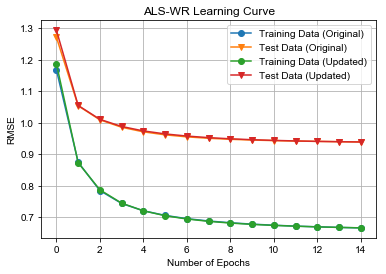

In [8]:
# Check performance by plotting train and test errors
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data (Original)');
plt.plot(range(n_epochs), test_errors, marker='v', label='Test Data (Original)');
# Added curves for errors from updated algorithm to make sure the accuracy is unchanged (aside from random deviations)
plt.plot(range(n_epochs), train_errors_fast, marker='o', label='Training Data (Updated)');
plt.plot(range(n_epochs), test_errors_fast, marker='v', label='Test Data (Updated)');
plt.title('ALS-WR Learning Curve')
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

As you can see, both training and test error monotonically decrease and converge over time. This means you don't seem to overfit (in which case the training error would still decrease, while the test error would increase).

The model seems to perform quite well, with a relatively low RMSE after convergence. The performance can be influenced by tweaking the hyperparameters $\lambda$ and $k$. In this case a manual grid search over $\lambda$ led to the regularisation weight of ``0.1``, whilst a $k$ of ``20`` was just an initial choice. Zhou et al. found a weight of ``0.065`` and $k$ of ``20`` to yield the best performance on their data set. In the end it comes down to your task at hand, so just play around with these parameters and make sure you analyse your learning curves thoroughly.

## Making Recommendations

So far you have framed the recommendation problem in terms of a simple $UV$-decomposition, derived the algorithm and trained your model. Now, to see the model in action let's recommend five movies to the user ``17`` (arbitrary choice) based on the learned latent features. In order to do this you first calculate the prediction matrix <img src="https://latex.codecogs.com/gif.latex?\hat{\mathbf{r}}_{ui}=\mathbf{p}_u^T\mathbf{q}_{i}&space;\&space;(4)" title="\hat{\mathbf{r}}_{ui}=\mathbf{p}_u^T\mathbf{q}_{i} \ (4)" /> and convert it to a dataframe for ease of use.

In [9]:
# Calculate prediction matrix R_hat (low-rank approximation for R)
R_hat = pd.DataFrame(np.dot(P.T,Q))
R = pd.DataFrame(R)

To get an idea of what you've achieved, let's compare some of your predictions for user ``17`` with the actual ratings.

In [10]:
# Compare true ratings of user 17 with predictions
ratings = pd.DataFrame(data=R.loc[16,R.loc[16,:] > 0]).head(n=5)
ratings['Prediction'] = R_hat.loc[16,R.loc[16,:] > 0]
ratings.columns = ['Actual Rating', 'Predicted Rating']

ratings

,Actual Rating,Predicted Rating
6,4.0,3.462720
8,3.0,3.134167
12,3.0,3.095745
110,3.0,2.737979
116,3.0,2.659850


As you can see, the model seems to have picked up the general trend of the user's ratings. To now give the top ``5`` recommendations to user ``17``, you simply want to find the five highest predicted movies that the user hasn't rated yet. To do that, use the original rating matrix as a logical index to pick out the appropriate predicted ratings, sort them in descending order and print out the top five recommendations.

In [11]:
predictions = R_hat.loc[16,R.loc[16,:] == 0] # Predictions for movies that the user 17 hasn't rated yet
top5 = predictions.sort_values(ascending=False).head(n=5)
recommendations = pd.DataFrame(data=top5)
recommendations.columns = ['Predicted Rating']

recommendations

,Predicted Rating
407,4.468448
168,4.300954
1366,4.191497
170,4.010846
49,3.977428


There you go! Now fetch some meta data about the movies *407*, *118*, *49*, *168* and *126* from the database and display your recommendations to the user.

## Summary
After solving the matrix factorisation problem with SGD [last time](http://online.cambridgecoding.com/notebooks/mhaller/implementing-your-own-recommender-systems-in-python-using-stochastic-gradient-descent-4#implementing-your-own-recommender-systems-in-python-using-stochastic-gradient-descent), you've now learned another method to approximate the rating matrix called **Alternating Least Squares** (**ALS**). As you have seen, the ALS trick of alternatingly fixing half of the parameters lets you treat the problem as a simple linear regression problem. After estimating the user and movie matrix, you calculated your approximate rating matrix (prediction matrix) to pull out the top 5 recommendations for a specific user.

Congratulations, you've mastered one of the fundamental ways of making recommendations. Stay tuned for future tutorials on how to employ more elaborate methods (e.g. hybrid recommender systems) to improve the performance of your models.

## References
- [Zhou et al. (2008)](http://www.grappa.univ-lille3.fr/~mary/cours/stats/centrale/reco/paper/MatrixFactorizationALS.pdf) Zhou, Y., Wilkinson, D., Schreiber, R. and Pan, R., 2008. Large-scale parallel collaborative filtering for the netflix prize. In Algorithmic Aspects in Information and Management (pp. 337-348). Springer Berlin Heidelberg.


<hr>
<strong>ABOUT THE AUTHORS</strong>

<img class="aligncenter size-thumbnail img-responsive" src="https://s31.postimg.org/km9i0wrp7/IMG_5951.jpg" alt="Moritz Haller"/>

Moritz has spent the past years in industry, working on business intelligence applications with the company he co-founded. He holds a BSc in Computer Science and is currently pursuing an MSc in Computer Science at University College London. His main interests lie in probabilistic modelling and machine learning.

<img class="aligncenter size-thumbnail img-responsive" src="http://s31.postimg.org/lchvjpirf/Agnes_profile.png" alt="Agnes Johannsdottir"/>

Agnes is a master student in Business Analytics at University College London. She studied Management Engineering in Iceland and worked for 2 years as an IT consultant in supply chain. Her main interests lie in using data science methods (especially machine learning) to apply in Retail and Supply Chain businesses.